In [58]:
## Bring in needed mods
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as ss, seaborn as sns
import sys
#sys.path.insert(0, '/../../QTL-functions/SCRIPTS/')
import qtlfunctions as QTLfun
import qtlmovie as QTLmovies

def allelic_manu(geno,pheno,x=0,y=1): ## geno and pheno need to be in the same position
    """
    Conducts a Mann-Whitney U test on the phenotype data in PHENO
    by the genotypic states listed in GENO.
    
    Assumes the order of data within GENO and PHENO are paired.
    Defaluts for the biallelic stat in GENO are 0 and 1; set in X and Y.
    
    Returns the -log10 of the calculated p-value
    """
    pheno = np.array(pheno) ## sets the type for the data as an array
    geno = np.array(geno)
    ## Gather phenotypes by genotypes 
    ## Parse the genotype data as True for 0 and then 1 and 
    ## take the asscoiated index within the phenotypic data array
    ## Return p-value
    return -np.log10(ss.mannwhitneyu(pheno[(geno==x)],pheno[(geno==y)])[1])

def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. 
        Return F-statistic.
    """
    coding = np.array(site,np.float)
    pheno = np.array(pheno,np.float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    R = (len_yhat/len_y)**2
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F,R

def association_logPval(site, pheno):
    F,R = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP,R

def association_logPval_sub(site, pheno):
    F,R = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [2]:
%matplotlib inline

In [3]:
## Set the random seed
np.random.seed(71191)

## Define parental labels
parents = ['Bt22','Ftc555-1']

In [9]:
## Set paths to phenotype data
## 1) the parental data (parents)
## 2) the initial set of segregants (old)
## 3) the latest set of segregants (new)
## Note, these data where previously processed
## And the halo per replicates / experimetns where calcualted
parent_data_path = "../../PHENOTYPE/bt22xftc555-1_melanin_parents.csv"
New_data_path = "../..//PHENOTYPE/bt22xftc555-1_melanin.csv"

## set path to genotype data and chromosome map
chrommap_path = '../../GENOTYPE/H99_chrommap.csv'

fs=12

In [10]:
## Bring in genotype data gather the segregants
## and show the frist five rows
loci_path = "../../GENOTYPE/Bt22xFtc555-1_loci_cor.csv.gz"
geno = pd.read_csv(loci_path, index_col = 0)
geno_segs = [s for s in geno.columns if s[:3] == "PMY"]
geno.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2931,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940
Oldindex,,,,,,,,,,,,,,,,,,,,,
5,1,25980,C.T,snp,25980,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
7,1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
12,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
15,1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
17,1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0


In [11]:
## Load in chrommap, check length, show head
chrommap = pd.read_csv(chrommap_path)
chrommap.shape[0] >= geno.Chrom.unique().shape[0]
chrommap.head()

,Chrom,Seqid,Length,Cumpos,Midpts
0,1,CP003820.1,2291499,0,1145749.5
1,2,CP003821.1,1621675,2291499,3102336.5
2,3,CP003822.1,1575141,3913174,4700744.5
3,4,CP003823.1,1084805,5488315,6030717.5
4,5,CP003824.1,1814975,6573120,7480607.5


In [12]:
## Bring in GFF file
gffpath = '../../GENOTYPE/FungiDB-46_CneoformansH99.gff'
names = ["Seqid", "Source", "Type", "Start", "End", "Score", 
         "Strand", "Phase", "Attribute"]
dtype = ["str","str","str","int","int","str","str","str","str"]

gff = pd.read_csv(gffpath,comment='#',
                  sep='\t',header=None,
                  names=names,dtype=dict(zip(names,dtype)))

gff['Strand'] = gff['Strand'].replace(dict(zip(['-','+'],[-1,1])))
gff['Parent'] = [a.split('Parent=')[-1].split(';')[0].split('ID=')[-1] 
                 for a in gff.Attribute ]

gff['Gene'] = [a.split('-t26')[0] for a in gff.Parent]

gff = gff.merge(chrommap)

In [13]:
## Gather parental data
## and average by replicate per experiment
PNd = pd.read_csv(parent_data_path)
PNda = PNd.groupby(["Sample"]).mean().reset_index().groupby("Sample").mean().reset_index()
#PNda.drop("Z", axis = 1, inplace = True)

## Gather PMY numbers of parents
Parent_PMY = PNda.Sample.tolist()

## view head
PNda.head()

,Sample,Replicate,Melanin
0,PMY2649,18.5,13340.877778
1,PMY2650,18.5,1598.561111


In [14]:
## Gather the latest data and average across repliacates, view head
Nd = pd.read_csv(New_data_path)
Nda = Nd[~(Nd.isin(Parent_PMY))].groupby("Sample").mean().reset_index()
Nda.head()

,Sample,Replicate,Melanin
0,PMY2556,2.0,950.066667
1,PMY2558,2.0,5484.500000
2,PMY2559,2.0,1884.333333
3,PMY2560,2.0,787.233333
4,PMY2561,2.0,1292.100000


In [15]:
## Concatonate resluts
Halo = pd.concat([PNda, Nda]).reset_index(drop = True)

## Set index
Halo.index = Halo.Sample
## View head
Halo.head()

,Sample,Replicate,Melanin
Sample,,,
PMY2649,PMY2649,18.5,13340.877778
PMY2650,PMY2650,18.5,1598.561111
PMY2556,PMY2556,2.0,950.066667
PMY2558,PMY2558,2.0,5484.500000
PMY2559,PMY2559,2.0,1884.333333


In [16]:
Nd.head()

,Sample,Replicate,Melanin
0,PMY2556,1,1307.8
1,PMY2556,2,1141.3
2,PMY2556,3,401.1
3,PMY2558,1,5248.8
4,PMY2558,2,5146.0


In [17]:
Nd_rm = Nd[~Nd.Sample.isin(['PMY2649', 'PMY2650'])]

In [18]:
spr_piv = Nd_rm.pivot_table(index = 'Sample',
          columns = 'Replicate',
         values = 'Melanin',
               aggfunc= 'mean')

spr_piv.head()

Replicate,1,2,3
Sample,,,
PMY2556,1307.8,1141.3,401.1
PMY2558,5248.8,5146.0,6058.7
PMY2559,1784.6,2415.4,1453.0
PMY2560,1448.0,730.0,183.7
PMY2561,1727.3,1521.7,627.3


In [19]:
ss.spearmanr(spr_piv, nan_policy='omit')

SpearmanrResult(correlation=array([[1.        , 0.86414211, 0.86287858],
       [0.86414211, 1.        , 0.87491588],
       [0.86287858, 0.87491588, 1.        ]]), pvalue=array([[0.00000000e+00, 1.82191397e-91, 3.33408596e-91],
       [1.82191397e-91, 0.00000000e+00, 8.56205234e-97],
       [3.33408596e-91, 8.56205234e-97, 0.00000000e+00]]))

In [20]:
## Check the number of times each sample appears in dataframe
pmy, pn = np.unique(Halo.Sample.values, return_counts = True)

if np.max(pn)>1:
    print(pmy[(pn>1)])

In [21]:
## Gather segregants with both genotype and phenotype data
Map_pop = [s for s in Halo.Sample.unique() if s in geno_segs]
len(Map_pop) ## print # of segregants

307

In [22]:
myylabel = 'Light Reflected\n$\longleftarrow$more - melanin - less$\longrightarrow$'

In [23]:
Halo.to_csv('../../PHENOTYPE/bt22xftc555_melanin_average.csv',
            index=False)
Halo = Halo.loc[Map_pop,:]

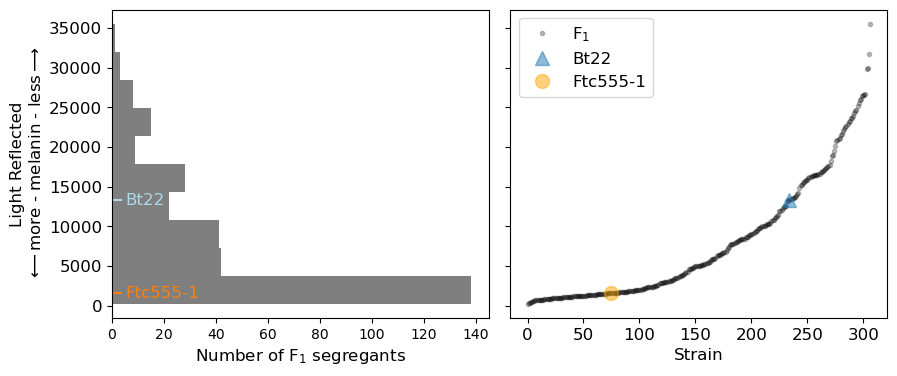

In [25]:
## Plot segregants
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)

plt.sca(ax[0])
## Plot all
plt.hist(Halo[(Halo.Sample.isin(Map_pop))].Melanin.values,
         color='k',alpha=0.5,
         orientation='horizontal')
         
## Label x and y axis
plt.ylabel(myylabel,fontsize=fs)
plt.xlabel('Number of F$_1$ segregants',fontsize=fs);

## Plot parents

ftc555_growth = Halo[(Halo.Sample==Parent_PMY[1])].Melanin
plt.hlines(ftc555_growth,
           0,4,color='tab:orange')

## annotate the parental strain name
plt.text(5,ftc555_growth,s=parents[1],
         va='center',ha='left',
         fontsize=fs,color='tab:orange')


## Plot parents
bt22_growth = Halo[(Halo.Sample==Parent_PMY[0])].Melanin
plt.hlines(bt22_growth,
           0,4,color='lightblue')
## annotate the parental strain name
plt.text(5,bt22_growth,s=parents[0],
         va='center',ha='left',
         fontsize=fs,color='lightblue');

#plt.xticks(np.arange(0,25,5),fontsize=fs)
plt.yticks(fontsize=fs)
## Summon the legend
#plt.legend(fontsize=fs);

plt.sca(ax[1])
Halo_sorted = Halo.sort_values('Melanin').reset_index(drop=True)
Halo_sorted_seg = Halo_sorted[~(Halo_sorted.Sample.isin(Parent_PMY))]
plt.plot(Halo_sorted.index,
        Halo_sorted.Melanin.values,
         'k.',alpha=0.25,label='F$_{1}$');



for i,p in enumerate(Parent_PMY):
    
    plt.plot(Halo_sorted[(Halo_sorted.Sample==p)].index,
               Halo_sorted[(Halo_sorted.Sample==p)].Melanin.values,
         'o' if i ==1 else '^',alpha=0.5,label=parents[i],
             color='orange' if i == 1 else 'tab:blue',ms=10);
    
#for i,p in enumerate(poor_growth):
#    
#    plt.plot(Halo_sorted[(Halo_sorted.Sample==p)].index,
#               Halo_sorted[(Halo_sorted.Sample==p)].Halo.values,
#             '.',label=p,color='r',ms=12,alpha=0.58);
    
plt.xlabel('Strain',fontsize=fs);
plt.xticks(fontsize=fs)
#plt.ylabel(myylabel,
#           fontsize=fs)
plt.legend(fontsize=fs);
plt.subplots_adjust(wspace=0.058)
plt.savefig("../../FIGURES/Melanin_pheno_dist_Bt22xFtc555-1.png",
            dpi=150,bbox_inches='tight');

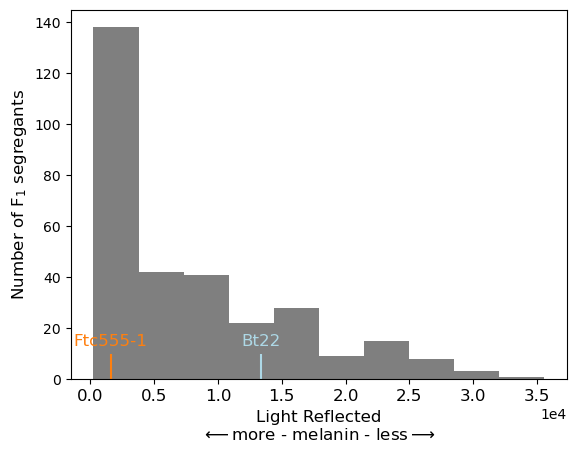

In [27]:
## Plot all
plt.hist(Halo[(Halo.Sample.isin(Map_pop))].Melanin.values,
         color='k',alpha=0.5,
         orientation='vertical')
         
## Label x and y axis
plt.xlabel(myylabel,fontsize=fs)
plt.ylabel('Number of F$_1$ segregants',fontsize=fs);

## Plot parents
ftc555_growth = Halo[(Halo.Sample==Parent_PMY[1])].Melanin
plt.vlines(ftc555_growth,
           0,10,color='tab:orange')

## annotate the parental strain name
plt.text(ftc555_growth,15,s=parents[1],
         va='center',ha='center',
         fontsize=fs,color='tab:orange')

bt22_growth = Halo[(Halo.Sample==Parent_PMY[0])].Melanin
plt.vlines(bt22_growth,
           0,10,color='lightblue')

## annotate the parental strain name
plt.text(bt22_growth,15,s=parents[0],
         va='center',ha='center',
         fontsize=fs,color='lightblue');

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xticks(fontsize=fs);


plt.savefig('../../FIGURES/Melanin_hist_Bt22xFtc555-1.png',
            dpi=150,bbox_inches='tight');

In [28]:
halo = Halo.loc[Map_pop]['Melanin'].values
halo[:5]

array([13340.87777778,  1598.56111111,   950.06666667,  5484.5       ,
        1884.33333333])

In [29]:
low = Halo.sort_values("Melanin").loc['PMY2649'].values[2]

high = Halo.sort_values("Melanin").loc['PMY2650'].values[2]

low, high

(13340.877777777778, 1598.5611111111111)

In [30]:
low_segs = Halo[(Halo['Melanin'] > low)].shape[0]

high_segs = Halo[(Halo['Melanin'] < high)].shape[0]

total_segs = Halo.shape[0]



#Halo[Halo.PMY == test]
low_segs, total_segs, high_segs

(72, 307, 75)

In [31]:
positive = low_segs/ total_segs*100

negative = high_segs/total_segs *100

transg = low_segs/ total_segs*100 + high_segs/total_segs *100

non_transg = 100 - transg

positive, negative, transg, non_transg ## percentage of segregants displaying transgressive segregation

(23.452768729641694, 24.429967426710096, 47.88273615635179, 52.11726384364821)

In [32]:
pvaldf = QTLfun.QTLmap(geno,QTLfun.association_logPval,
                         Map_pop,halo)

#pvaldf = QTLfun.QTLmap(geno,QTLfun.allelic_manu,
#                      Map_pop,halo)

In [33]:
pvaldf = pvaldf.sort_values(['Chrom','Pos']).reset_index(drop=True)

In [34]:
chrommap = QTLfun.chrommap(pvaldf)
chrompad = np.cumsum(200000*np.ones(len(chrommap)))
chrommap['Cumlen'] = chrommap.Cumlen + chrompad
chrommap['Midpts'] = chrommap.Midpts + chrompad
chrommap.head()

,Chrom,Length,Cumlen,Midpts
0,1,2264002,200000.0,1332001.0
1,2,1619187,2664002.0,3473595.5
2,3,1554360,4483189.0,5260369.0
3,4,1059391,6237549.0,6767244.5
4,5,1793420,7496940.0,8393650.0


## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(10,3)) ## Makes a figure instance
fig.set_facecolor('w')
for i,j in chrommap.iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values+cumpos,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
#plt.hlines(threshold,chrommap.Midpts.min(),
#           19*10**6,linewidth=1,alpha=0.5,
#           linestyle='--',color='k')

#plt.text(chrommap.Midpts.min()-100000,threshold,
#         '$\u03B1$ = 0.01',
#         fontsize=12,alpha=0.2,
#         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts, chrommap.Chrom,
           fontsize=12); ## set location, labels and fontsize of x tics.
plt.ylim(0,50)
plt.savefig("C:/Users/Thomas/Desktop/Melanin_QTL_Bt22xFtc555-1.png",
            dpi = 200, bbox_inches = "tight") ## Save figure

In [35]:
## Make a genotype by phenotype dataframe at QTL peak
## Find QTL idnex
#Qtl_ix = pvaldf.Pval.idxmax()

Qtl_ix = pvaldf.QTL.idxmax()

Qtlchorm = pvaldf.loc[Qtl_ix,'Chrom']

## Take genotype values and rename column
Qtl = pvaldf.loc[[Qtl_ix], sorted(Map_pop)].T
Qtl.columns = ["GT"]

## Find assocaited phenotypes view head
Qtl["Melanin"] = Halo.loc[sorted(Map_pop), "Melanin"].values
Qtl.head()

,GT,Melanin
PMY2556,1,950.066667
PMY2558,1,5484.500000
PMY2559,1,1884.333333
PMY2560,1,787.233333
PMY2561,1,1292.100000


In [36]:
Qtl_ix

29363

In [37]:
Qtl_means = Qtl.groupby("GT")["Melanin"].agg("mean").reset_index()

C:\Users\tsauters\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 38.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


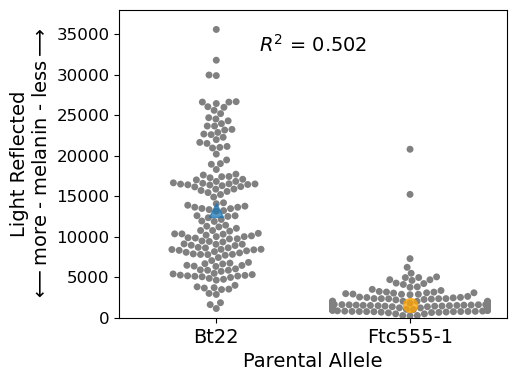

In [39]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
## Make a genotype by phenotype plot at QTL peak
## plto swarm
sns.swarmplot(x = "GT", y = "Melanin", data = Qtl, color = "grey");


for i,p in enumerate(Parent_PMY):
    
    plt.plot(Qtl[(Qtl.index==p)].index,
               Qtl[(Qtl.index==p)].Melanin.values,
         'o' if i ==1 else '^',alpha=0.75,label=parents[i],
             color='orange' if i == 1 else 'tab:blue',ms=10,
             zorder = 10);

plt.xticks([0,1], parents, fontsize = 14);
plt.yticks(fontsize = 12);
plt.xlabel("Parental Allele", fontsize = 14);
plt.ylim(0, 38000)
plt.ylabel(myylabel,fontsize=14);
#plt.text(0.5,37300,s='Chromosome 8',va='top',ha='center',fontsize=14);
plt.text(0.5,35000,s='$R^2$ = 0.502',va='top',ha='center',fontsize=14);
plt.savefig("../../FIGURES/Melanin_Chr8_dist_Bt22xFtc555-1.png", 
            dpi = 100, bbox_inches = "tight")

In [40]:
temp = pvaldf[(pvaldf.Chrom == Qtlchorm)]

In [41]:
Halo['QTL'] = geno.loc[Qtl_ix,Map_pop].values

In [42]:
#Halo.drop("Replicate", axis = 1, inplace=True)

Halo.head()

,Sample,Replicate,Melanin,QTL
Sample,,,,
PMY2649,PMY2649,18.5,13340.877778,0
PMY2650,PMY2650,18.5,1598.561111,1
PMY2556,PMY2556,2.0,950.066667,1
PMY2558,PMY2558,2.0,5484.500000,0
PMY2559,PMY2559,2.0,1884.333333,0


In [43]:
Halo.head()

,Sample,Replicate,Melanin,QTL
Sample,,,,
PMY2649,PMY2649,18.5,13340.877778,0
PMY2650,PMY2650,18.5,1598.561111,1
PMY2556,PMY2556,2.0,950.066667,1
PMY2558,PMY2558,2.0,5484.500000,0
PMY2559,PMY2559,2.0,1884.333333,0


In [44]:
import statsmodels.formula.api as smf, seaborn as sns
res = smf.ols('Melanin~GT',data=Qtl).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     307.7
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           4.01e-48
Time:                        12:58:52   Log-Likelihood:                -3075.9
No. Observations:                 307   AIC:                             6156.
Df Residuals:                     305   BIC:                             6163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.305e+04    426.895     30.577      0.000    1.22e+04    1.39e+04
GT         -1.093e+04    623.318    -17.543      0.000   -1.22e+04   -9708.048
==============================================================================
Omnibus:                       55.563   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.150
Skew:                           0.990   Prob(JB):                     1.79e-22
Kurtosis:                       4.977   Cond. No.                         2.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
-np.log10(res.pvalues[1])

47.39652354931347

In [46]:
r2 = np.round(res.rsquared,2)
r2

0.5

In [47]:
perms = 1000 
pheno = Halo.loc[sorted(Map_pop),'Melanin'].values 
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

In [48]:
threshold = 4.46795028084801
#threshold = -1

#loci = geno[sorted(Map_pop)].drop_duplicates()

#if threshold < 0: 
#    null = [] 
#    i = 0 
#    while len(null) < perms:

    ## Permute the phenotypic space
#        null.append(loci.apply(allelic_manu,
#                           args=[perms_pheno[i]],
#                           axis=1).max())
#        i += 1 ## Add one to i

## Take the upper 95th percentile    
#threshold = np.percentile(null,95 if perms <= 1000 else 99)

In [49]:
total8 = pvaldf[pvaldf.QTL > threshold]

total8.Pos.min(), total8.Pos.max()

(639191, 922914)

In [50]:
chrommap

,Chrom,Length,Cumlen,Midpts
0,1,2264002,200000.0,1332001.0
1,2,1619187,2664002.0,3473595.5
2,3,1554360,4483189.0,5260369.0
3,4,1059391,6237549.0,6767244.5
4,5,1793420,7496940.0,8393650.0
5,6,1417305,9490360.0,10199012.5
6,7,1374738,11107665.0,11795034.0
7,8,1387111,12682403.0,13375958.5
8,9,1155758,14269514.0,14847393.0
9,10,1051064,15625272.0,16150804.0


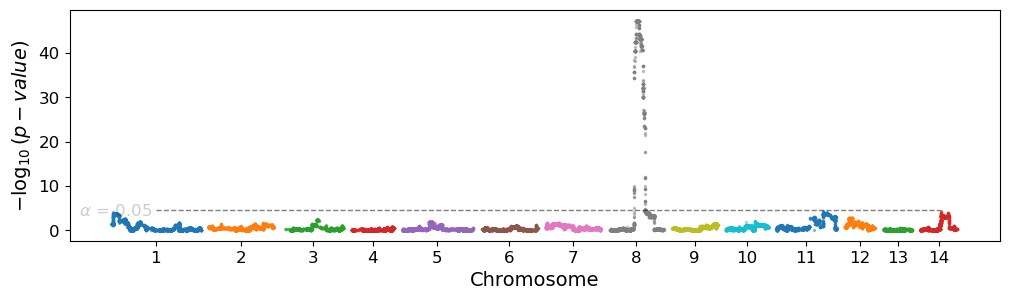

In [51]:
## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values+cumpos,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
    
plt.hlines(threshold,chrommap.Midpts.min(),
           21*10**6,linewidth=1,alpha=0.5,
           linestyle='--',color='k')

plt.text(chrommap.Midpts.min()-100000,threshold,
         '$\u03B1$ = 0.05',
         fontsize=12,alpha=0.2,
         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.
#plt.ylim(0,10)


plt.savefig("../../FIGURES/Melanin_QTL_Bt22xFtc555-1.png", 
            dpi = 100, bbox_inches = "tight")

In [52]:
## sub divide and reconduct QTL mappin
Map_pop0 = Qtl[(Qtl.GT == 0)].index.tolist()
Map_pop1 =Qtl[(Qtl.GT == 1)].index.tolist()

## View number of progeny in each group
len(Map_pop0), len(Map_pop1)

(163, 144)

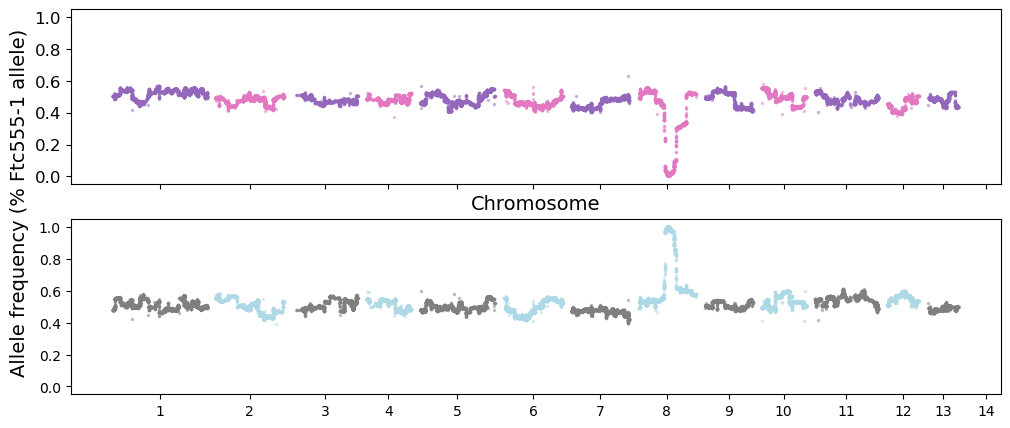

In [53]:
## Plot results of split (based on allele at QTL 8) QTL analysis
fig,ax = plt.subplots(2,1,figsize=(12,5), 
                      sharex = True, sharey = True) ## Makes a figure instance
for i,j in chrommap[:-1].iterrows(): ## For ech row in dataframe chrommap do this ...    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.sca(ax[0]) ## For Bt22 progeny
    plt.plot(temp.Pos.values+cumpos,
             temp[Map_pop0].mean(axis=1),
             '.',markersize=3,alpha=0.4,
             color='tab:purple' if i%2==0 else 'tab:pink'); ## plots the data x vs y

    
    plt.sca(ax[1]) ## For Ftc555-1 progeny
    plt.plot(temp.Pos.values+cumpos,
             temp[Map_pop1].mean(axis=1),
             '.',markersize=3,alpha=0.4,
            color='tab:grey' if i%2==0 else 'lightblue'); ## plots the data x vs y
    
plt.sca(ax[0])
plt.ylabel('Allele frequency (% Ftc555-1 allele)',fontsize=14,y=-0.1)

plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.

#plt.savefig("../../FIGURES/Amoeba_Halo_Allele_Freq_split_Bt22xFtc555-1.png", 
#            dpi = 200, bbox_inches = "tight")

In [85]:
## For sub population with Bt22 allele at QTL
## conduct QTL mapping and merge results
## taking just p-value column
loci0 = geno[(geno.Chrom != 8)][sorted(Map_pop0)].drop_duplicates()
loci0['Pval'] = loci0.apply(allelic_manu, 
                            args=[Halo.loc[sorted(Map_pop0), "Melanin"]], 
                            axis=1)
pvaldf["Pval0"] = geno.merge(loci0, how = 'left')["Pval"].replace(np.inf,np.nan)

In [86]:
## For sub population with Ftc555-1 allele at QTL
## conduct QTL mapping and merge results
## taking just p-value column
loci1 = geno[(geno.Chrom != 8)][sorted(Map_pop1)].drop_duplicates()

#loci1 = loci1[~(loci1.index.isin(pvaldf[(pvaldf.Pval1>10)].index))]
loci1['Pval'] = loci1.apply(allelic_manu, 
                            args=[Halo.loc[sorted(Map_pop1), "Melanin"]], 
                            axis=1)

pvaldf["Pval1"] = geno.merge(loci1, how = 'left')["Pval"].replace(np.inf,np.nan)

In [88]:
## view head of new p-values
pvaldf.head()[['QTL','Pval0','Pval1']]

,QTL,Pval0,Pval1
0,1.470231,2.710886,0.006984
1,1.470231,2.710886,0.006984
2,1.470231,2.710886,0.006984
3,1.470231,2.710886,0.006984
4,1.470231,2.710886,0.006984


In [89]:
#threshold_subificance threshold for QTL mapping`\
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
#threshold_sub = 4.174006779033505 allelic_manuhreshold
#threshold_sub0 = 4.45 #for the manu
threshold_sub0 =4.072346658748056
## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno0 = Halo.loc[sorted(Map_pop0),'Melanin'].values
perms_pheno0 = [np.random.permutation(pheno0) for i in range(perms)]

## Gather loci and intiate null distrbution
loci0 = geno[(geno.Chrom != 8)][sorted(Map_pop0)].drop_duplicates()

if threshold_sub0 < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci0.apply(allelic_manu,
                               args=[perms_pheno0[i]],
                               axis=1).replace(np.inf,np.nan).dropna().max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold_sub0 = np.percentile(null,95 if perms <= 1000 else 99)

In [90]:
#threshold_subificance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
#threshold_sub = 4.174006779033505 ## 0.05 threshold
#threshold_sub = 4.3 #for the manu
threshold_sub = 4.022490242845576
## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = Halo.loc[sorted(Map_pop1),'Melanin'].values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = geno[(geno.Chrom != 8)][sorted(Map_pop1)].drop_duplicates()

if threshold_sub < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(allelic_manu,
                               args=[perms_pheno[i]],
                               axis=1).replace(np.inf,np.nan).dropna().max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold_sub = np.percentile(null,95 if perms <= 1000 else 99)

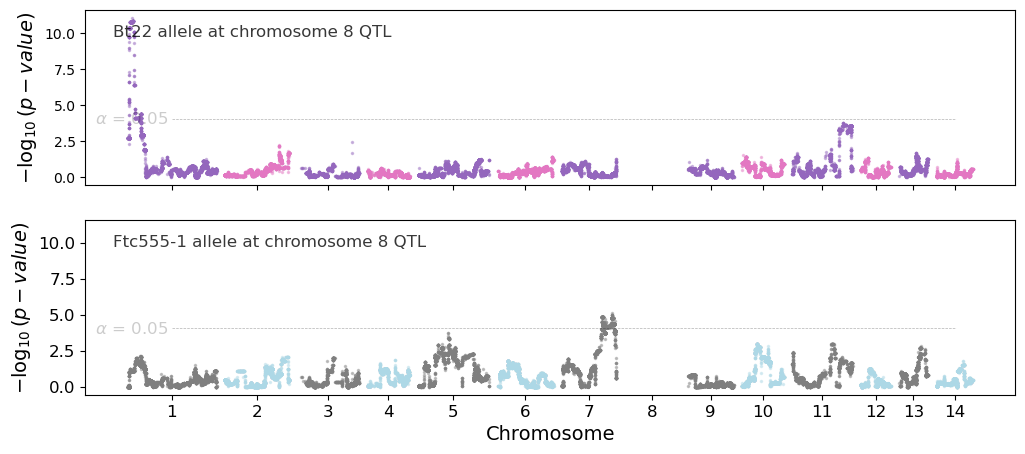

In [91]:
## Plot results of split (based on allele at QTL 8) QTL analysis
fig,ax = plt.subplots(2,1,figsize=(12,5), 
                      sharex = True, sharey = True) ## Makes a figure instance
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap do this ...    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.sca(ax[0]) ## For Bt22 progeny
    #plt.hlines(threshold_sub,0,19*10**6,alpha=0.5,
    #           linestyle='--',linewidth=1,color='k')
    plt.plot(temp.Pos.values+cumpos,temp.Pval0.values,
             '.',markersize=3,alpha=0.4,
             color='tab:purple' if i%2==0 else 'tab:pink'); ## plots the data x vs y

    
    plt.sca(ax[1]) ## For Ftc555-1 progeny

    
    
    plt.plot(temp.Pos.values+cumpos,temp.Pval1.values,
             '.',markersize=3,alpha=0.4,
            color='tab:grey' if i%2==0 else 'lightblue'); ## plots the data x vs y
    
for i in [0,1]:
    plt.sca(ax[i])
    plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
    plt.title("%s allele at chromosome 8 QTL"%parents[i], 
              x = .03, y = .8, ha = "left",fontsize=12,alpha=0.78)

    if i == 0:     
        plt.hlines(threshold_sub,chrommap.Midpts.min(),
               21*10**6,alpha=0.3,
                   linestyle='--',linewidth=0.5,color='k')
        plt.text(chrommap.Midpts.min()-100000,threshold_sub,
             '$\u03B1$ = 0.05',
                 fontsize=12,alpha=0.2,ha='right',va='center')
        
    else: 
        plt.hlines(threshold_sub0,chrommap.Midpts.min(),
               21*10**6,alpha=0.3,
                   linestyle='--',linewidth=0.5,color='k')
        plt.text(chrommap.Midpts.min()-100000,threshold_sub,
             '$\u03B1$ = 0.05',
                 fontsize=12,alpha=0.2,ha='right',va='center')
        


plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.

plt.savefig("../../FIGURES/Melanin_QTL_split_Bt22xFtc555-1.png", 
            dpi = 150, bbox_inches = "tight")

In [382]:
## Make a genotype by phenotype dataframe at QTL peak
## Find QTL idnex
#Qtl_ix = pvaldf.Pval.idxmax()

Qtl_ix0 = pvaldf.Pval0.idxmax()

Qtlchorm0 = pvaldf.loc[Qtl_ix0,'Chrom']

## Take genotype values and rename column
Qtl0 = pvaldf.loc[[Qtl_ix0], sorted(Map_pop0)].T
Qtl0.columns = ["GT"]

## Find assocaited phenotypes view head
Qtl0["Melanin"] = Halo.loc[sorted(Map_pop0), "Melanin"].values
Qtl0.head()

,GT,Melanin
PMY2565,0,6027.100000
PMY2567,1,21630.600000
PMY2568,0,10758.400000
PMY2570,0,15196.966667
PMY2572,1,21504.033333


In [383]:
import statsmodels.formula.api as smf, seaborn as sns
res0 = smf.ols('Melanin~GT',data=Qtl0).fit()
res0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     56.54
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           3.64e-12
Time:                        10:51:23   Log-Likelihood:                -1653.2
No. Observations:                 163   AIC:                             3310.
Df Residuals:                     161   BIC:                             3317.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9389.5964    686.987     13.668      0.000    8032.929    1.07e+04
GT          7282.9105    968.580      7.519      0.000    5370.152    9195.669
==============================================================================
Omnibus:                       10.803   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.036
Skew:                           0.616   Prob(JB):                      0.00401
Kurtosis:                       3.325   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [384]:
## Make a genotype by phenotype dataframe at QTL peak
## Find QTL idnex
#Qtl_ix = pvaldf.Pval.idxmax()

Qtl_ix1 = pvaldf.Pval1.idxmax()

Qtlchorm1 = pvaldf.loc[Qtl_ix1,'Chrom']

## Take genotype values and rename column
Qtl1 = pvaldf.loc[[Qtl_ix1], sorted(Map_pop1)].T
Qtl1.columns = ["GT"]

## Find assocaited phenotypes view head
Qtl1["Melanin"] = Halo.loc[sorted(Map_pop1), "Melanin"].values
Qtl1.head()

,GT,Melanin
PMY2556,0,950.066667
PMY2558,1,5484.500000
PMY2559,0,1884.333333
PMY2560,0,787.233333
PMY2561,1,1292.100000


In [385]:
import statsmodels.formula.api as smf, seaborn as sns
res1 = smf.ols('Melanin~GT',data=Qtl1).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     12.06
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           0.000684
Time:                        10:51:23   Log-Likelihood:                -1311.4
No. Observations:                 144   AIC:                             2627.
Df Residuals:                     142   BIC:                             2633.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1533.8765    248.828      6.164      0.000    1041.991    2025.762
GT          1276.1898    367.543      3.472      0.001     549.626    2002.753
==============================================================================
Omnibus:                      191.553   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8679.275
Skew:                           5.219   Prob(JB):                         0.00
Kurtosis:                      39.573   Cond. No.                         2.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [386]:
## Sub set qtl 5 data
qtl1 = pvaldf[(pvaldf.Chrom==1)]

In [387]:
qtl1max = qtl1[(qtl1.Pval0==qtl1.Pval0.max())]
qtl1_l,qtl1_r = qtl1max.Pos.min(),qtl1max.Pos.max()
qtl1_l,qtl1_r

(144058, 144058)

In [388]:
## Gather information on chromosome 5 QTL
QTL1_ix = qtl1.Pval0.idxmax()
QTL1_gt = pvaldf.loc[QTL1_ix,:][Map_pop]
Qtl['QTL1'] = QTL1_gt
Qtl['Chromosome 1 QTL'] = Qtl['QTL1'].replace(dict(zip([0,1],parents)))
Qtl.head()

,GT,Melanin,QTL1,Chromosome 1 QTL
PMY2556,1,950.066667,1,Ftc555-1
PMY2558,1,5484.500000,0,Bt22
PMY2559,1,1884.333333,1,Ftc555-1
PMY2560,1,787.233333,0,Bt22
PMY2561,1,1292.100000,0,Bt22


In [389]:
Qtl0_means = Qtl.groupby("QTL1")["Melanin"].agg("mean").reset_index()

In [390]:
Qtl0_means

,QTL1,Melanin
0,0,6218.318697
1,1,9451.564266


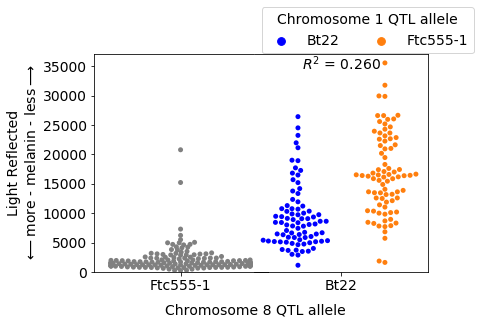

In [391]:
fig,ax = plt.subplots(1,2,figsize=(6,4),sharey=False)


plt.sca(ax[0])
sns.swarmplot(x='GT',
              y='Melanin',data=Qtl[(Qtl.GT==1)],size=5,
             color='grey')
plt.xlabel(' ')
plt.xticks([0],['Ftc555-1'],fontsize=14)
plt.ylabel(myylabel, fontsize = 14);
plt.yticks(fontsize=14)
plt.ylim(0,37000)


plt.sca(ax[1])
sns.swarmplot(x='Chromosome 1 QTL',
              y='Melanin',data=Qtl[(Qtl.GT==0)],
              hue='Chromosome 1 QTL',size=5,
              palette=dict(zip(parents,['blue','tab:orange'])))
plt.xlabel(' ');plt.ylabel(' ')


ax[1].spines['left'].set_visible(False)
#ax.spines['top'].set_visible(False)

plt.xticks([0.5],['Bt22'],fontsize=14);
plt.yticks([])
fig.text(x=0.5,y=-0.01,s='Chromosome 8 QTL allele',
         fontsize=14,va='center',ha='center')
lg = plt.legend(fontsize=14,bbox_to_anchor=(1.3,1.25),ncol=2,
           title='Chromosome 1 QTL allele')
plt.text(0.5,37000,s='$R^2$ = 0.260',va='top',ha='center',fontsize=14);
lg.get_title().set_fontsize(14)
plt.ylim(0,37000)
plt.subplots_adjust(wspace=-.075)
plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Amoeba_Melanin_by_genotype_split_Chr1_Bt22xFtc555-1.png", 
            dpi = 100, bbox_inches = "tight")

In [392]:
## Sub set qtl 5 data
qtl7 = pvaldf[(pvaldf.Chrom==7)]

In [393]:
qtl7max = qtl7[(qtl7.Pval1==qtl7.Pval1.max())]
qtl7_l,qtl7_r = qtl7max.Pos.min(),qtl7max.Pos.max()
qtl7_l,qtl7_r

(1350126, 1350126)

In [394]:
## Gather information on chromosome 5 QTL
QTL7_ix = qtl7.Pval1.idxmax()
QTL7_gt = pvaldf.loc[QTL7_ix,:][Map_pop]
Qtl['QTL7'] = QTL7_gt
Qtl['Chromosome 7 QTL'] = Qtl['QTL7'].replace(dict(zip([0,1],parents)))
Qtl.head()

,GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL
PMY2556,1,950.066667,1,Ftc555-1,0,Bt22
PMY2558,1,5484.500000,0,Bt22,1,Ftc555-1
PMY2559,1,1884.333333,1,Ftc555-1,0,Bt22
PMY2560,1,787.233333,0,Bt22,0,Bt22
PMY2561,1,1292.100000,0,Bt22,1,Ftc555-1


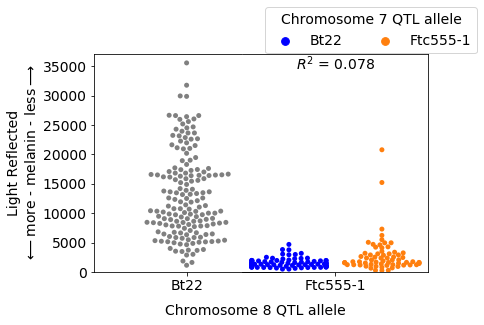

In [395]:
fig,ax = plt.subplots(1,2,figsize=(6,4),sharey=False)


plt.sca(ax[0])
sns.swarmplot(x='GT',
              y='Melanin',data=Qtl[(Qtl.GT==0)],size=5,
             color='grey')
plt.xlabel(' ')
plt.xticks([0],['Bt22'],fontsize=14)
plt.ylabel(myylabel, fontsize = 14);
plt.yticks(fontsize=14)
plt.ylim(0,37000)


plt.sca(ax[1])
sns.swarmplot(x='Chromosome 7 QTL',
              y='Melanin',data=Qtl[(Qtl.GT==1)],
              hue='Chromosome 7 QTL',size=5,
              palette=dict(zip(parents,['blue','tab:orange'])))
plt.xlabel(' ');plt.ylabel(' ')

ax[1].spines['left'].set_visible(False)
#ax.spines['top'].set_visible(False)

plt.xticks([0.5],['Ftc555-1'],fontsize=14);
plt.yticks([])
fig.text(x=0.5,y=-0.01,s='Chromosome 8 QTL allele',
         fontsize=14,va='center',ha='center')
lg = plt.legend(fontsize=14,bbox_to_anchor=(1.3,1.25),ncol=2,
           title='Chromosome 7 QTL allele')
plt.text(0.5,37000,s='$R^2$ = 0.078',va='top',ha='center',fontsize=14);
lg.get_title().set_fontsize(14)
plt.ylim(0,37000)
plt.subplots_adjust(wspace=-.2)
plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Amoeba_Melanin_by_genotype_split_Chr7_Bt22xFtc555-1.png", 
            dpi = 100, bbox_inches = "tight")

In [396]:
halo_path = '../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_pvaldf.csv'

In [397]:
amoeba = pd.read_csv(halo_path, index_col = 0)

In [398]:
amoeba.head()

,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,PMY2559,...,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940,Pval
Chrom,,,,,,,,,,,,,,,,,,,,,
1,25980,C.T,snp,25980,1.0,1.0,0.491857,1,0,1,...,1,1,0,1,0,1,1,0,0,0.419893
1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857,1,0,1,...,1,1,0,1,0,1,1,0,0,0.429060
1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857,1,0,1,...,1,1,0,1,0,1,1,0,0,0.429060
1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857,1,0,1,...,1,1,0,1,0,1,1,0,0,0.429060
1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857,1,0,1,...,1,1,0,1,0,1,1,0,0,0.429060


In [399]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

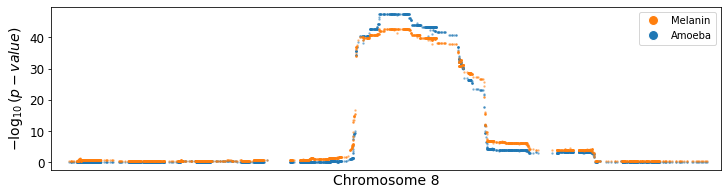

In [400]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Melanin',
                          markerfacecolor='tab:orange', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Amoeba',
                          markerfacecolor='tab:blue', markersize=10)] # for making a custom legend


## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
 ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
temp = pvaldf[(pvaldf.Chrom == 8)] ## subsets the dataframe on Chrom
cumposs = chrommap[(chrommap.Chrom == 8)].Cumlen.values ## Assigns the cumlative postion from chrommap to
    
plt.plot(temp.Pos.values+cumposs,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y

temp = amoeba[(amoeba.index == 8)] ## subsets the dataframe on Chrom
cumposs = chrommap[(chrommap.Chrom == 8)].Cumlen.values ## Assigns the cumlative postion from chrommap to
    
plt.plot(temp.Pos.values+cumposs,temp.Pval.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome 8',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:-1], chrommap.Chrom[:-1],
           fontsize=12); ## set location, labels and fontsize of x tics.
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax.legend(handles=legend_elements, loc='upper right')

plt.xlim(12682403.0, 14100000.0);

#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_Amoeba_QTL_Comparison_Bt22xFtc555-1.png", 
#            dpi = 100, bbox_inches = "tight")

In [401]:
geno_ch8 = QTLfun.findchrom(geno,c=8)
geno_ch8.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2931,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940
Oldindex,,,,,,,,,,,,,,,,,,,,,
52560,8,38163,TCTGAA.TATGAA.TTTGAA,snp,38163,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0
52561,8,40940,GCT.ACT,snp,40940,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0
52562,8,42061,G.A,snp,42061,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0
52564,8,42150,CAT.TAT,snp,42150,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0
52565,8,44571,A.G,snp,44571,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0


In [402]:
Mel = Halo.loc[Map_pop]['Melanin'].values

In [403]:
#cil,cir,boots = QTLfun.bootci(geno_ch8,QTLfun.allelic_manu,
#                                Map_pop,Mel,nboots=500)

# View head of boots
#boots.head()

In [404]:
#cil, cir

In [405]:
#boots.to_csv('../../NOTES/BT_melanin_bootstraps.csv.gz', index = False)

In [406]:
#bring in melanin boots that were made above (commented cells)

cil = 726391.0

cir = 733023.0

boots = pd.read_csv('../../NOTES/BT_melanin_bootstraps.csv.gz', index_col=False)

boots.head()

,l,r,m,QTL
0,694520,757311,729429.0,46.219791
1,694185,757311,728350.0,45.770203
2,726391,726391,726391.0,45.367446
3,726391,726391,726391.0,48.037996
4,694185,757311,728350.0,47.004788


In [407]:
meba_path = '../../NOTES/Bt22xFtc555-1_QTL8_genotype_phenotype.csv'

In [408]:
meba = pd.read_csv(meba_path)

meba.rename(columns = {"Unnamed: 0": "Sample"}, inplace = True)

meba.set_index('Sample', drop = False, inplace = True)

In [409]:
meba.head()

,Sample,GT,Halo,QTL5,Chromosome 5 QTL
Sample,,,,,
PMY2556,PMY2556,1.0,21.406409,0.0,Bt22
PMY2558,PMY2558,1.0,7.051599,0.0,Bt22
PMY2559,PMY2559,1.0,4.329024,1.0,Ftc555-1
PMY2560,PMY2560,1.0,3.896766,1.0,Ftc555-1
PMY2561,PMY2561,1.0,10.764495,0.0,Bt22


In [410]:
halo = meba.loc[Map_pop]['Halo'].values

In [411]:
#cila,cira,bootsa = QTLfun.bootci(geno_ch8,QTLfun.allelic_manu,
#                                Map_pop,halo,nboots=500)

# View head of boots
#bootsa.head()

In [412]:
#bootsa.to_csv('../../NOTES/BT_amoeba_bootstraps.csv.gz', index = False)

In [413]:
#cila, cira

In [414]:
#bring in melanin boots that were made above (commented cells)

cila = 726529.0

cira = 773990.0

bootsa = pd.read_csv('../../NOTES/BT_amoeba_bootstraps.csv.gz', index_col=False)

bootsa.head()

,l,r,m,QTL
0,694185,757311,728350.0,41.629840
1,694185,757311,728350.0,40.214532
2,694583,757311,729668.0,38.012842
3,694520,759761,731723.5,43.479045
4,694185,757311,728350.0,41.866612


In [415]:
bootsa.l.mean(), bootsa.r.mean()

(695702.782, 759410.244)

In [416]:
boots.l.mean(), boots.r.mean()

(713902.26, 738938.574)

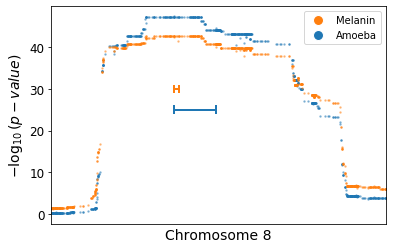

In [417]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Melanin',
                          markerfacecolor='tab:orange', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Amoeba',
                          markerfacecolor='tab:blue', markersize=10)] # for making a custom legend


## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(6,4)) ## Makes a figure instance
 ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
temp = pvaldf[(pvaldf.Chrom == 8)] ## subsets the dataframe on Chrom
cumposs = chrommap[(chrommap.Chrom == 8)].Cumlen.values ## Assigns the cumlative postion from chrommap to
    
plt.plot(temp.Pos.values+cumposs,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y

temp = amoeba[(amoeba.index == 8)] ## subsets the dataframe on Chrom
cumposs = chrommap[(chrommap.Chrom == 8)].Cumlen.values ## Assigns the cumlative postion from chrommap to
    
plt.plot(temp.Pos.values+cumposs,temp.Pval.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome 8',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:-1], chrommap.Chrom[:-1],
           fontsize=12); ## set location, labels and fontsize of x tics.
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax.legend(handles=legend_elements, loc='upper right')

#CI for melanin
plt.hlines(30,cil + 12682403.0,cir + 12682403.0,color='tab:orange',linewidth=2)
plt.vlines(cil + 12682403.0, 31, 29, color='tab:orange',linewidth=2)
plt.vlines(cir + 12682403.0, 31, 29, color='tab:orange',linewidth=2)

#CI for Amoeba
plt.hlines(25,cila + 12682403.0,cira + 12682403.0,color='tab:blue',linewidth=2)
plt.vlines(cila + 12682403.0, 26, 24, color='tab:blue',linewidth=2)
plt.vlines(cira + 12682403.0, 26, 24, color='tab:blue',linewidth=2)

plt.xlim(13270000.0, 13650000.0);

plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_Amoeba_QTL_Comparison_Bt22xFtc555-1.png", 
            dpi = 100, bbox_inches = "tight")

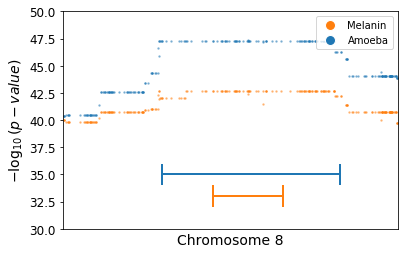

In [418]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Melanin',
                          markerfacecolor='tab:orange', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Amoeba',
                          markerfacecolor='tab:blue', markersize=10)] # for making a custom legend


## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(6,4)) ## Makes a figure instance
 ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
temp = pvaldf[(pvaldf.Chrom == 8)] ## subsets the dataframe on Chrom
cumposs = chrommap[(chrommap.Chrom == 8)].Cumlen.values ## Assigns the cumlative postion from chrommap to
    
plt.plot(temp.Pos.values,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y

temp = amoeba[(amoeba.index == 8)] ## subsets the dataframe on Chrom
cumposs = chrommap[(chrommap.Chrom == 8)].Cumlen.values ## Assigns the cumlative postion from chrommap to
    
plt.plot(temp.Pos.values,temp.Pval.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome 8',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:-1], chrommap.Chrom[:-1],
           fontsize=12); ## set location, labels and fontsize of x tics.
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax.legend(handles=legend_elements, loc='upper right')

#CI for melanin
plt.hlines(33,boots.l.mean(),boots.r.mean(),color='tab:orange',linewidth=2)
plt.vlines(boots.l.mean(), 34, 32, color='tab:orange',linewidth=2)
plt.vlines(boots.r.mean(), 34, 32, color='tab:orange',linewidth=2)

#CI for Amoeba
plt.hlines(35,bootsa.l.mean(),bootsa.r.mean(),color='tab:blue',linewidth=2)
plt.vlines(bootsa.l.mean(), 36, 34, color='tab:blue',linewidth=2)
plt.vlines(bootsa.r.mean(), 36, 34, color='tab:blue',linewidth=2)
plt.ylim(30,50)
plt.xlim(660000,780000);

#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_Amoeba_QTL_Comparison_Bt22xFtc555-1.png", 
#            dpi = 100, bbox_inches = "tight")

In [419]:
geno_8ci = pd.merge(geno_ch8, pvaldf)

geno_8ci.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940,QTL,Pval0,Pval1
0,8,38163,TCTGAA.TATGAA.TTTGAA,snp,38163,8.0,8.0,0.491857,1,1,...,1,0,1,0,0,1,0,0.059627,0.478297,4.667636
1,8,40940,GCT.ACT,snp,40940,8.0,8.0,0.491857,1,1,...,1,0,1,0,0,1,0,0.059627,0.448963,4.667636
2,8,42061,G.A,snp,42061,8.0,8.0,0.491857,1,1,...,1,0,1,0,0,1,0,0.059627,0.448963,4.667636
3,8,42150,CAT.TAT,snp,42150,8.0,8.0,0.491857,1,1,...,1,0,1,0,0,1,0,0.059627,0.370986,4.667636
4,8,44571,A.G,snp,44571,8.0,8.0,0.491857,1,1,...,1,0,1,0,0,1,0,0.059627,0.530440,4.667636


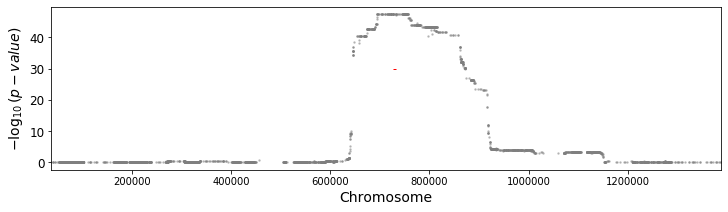

In [420]:
## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = geno_8ci[(geno_8ci.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
    
#plt.hlines(threshold,chrommap.Midpts.min(),
#           21*10**6,linewidth=1,alpha=0.5,
#           linestyle='--',color='k')

plt.hlines(30,cil,cir,color='r',linewidth=1)

#plt.text(chrommap.Midpts.min()-100000,threshold,
#         '$\u03B1$ = 0.05',
#         fontsize=12,alpha=0.2,
#         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
#plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
#           fontsize=12); ## set location, labels and fontsize of x tics.
plt.xlim(38163,1387111);


#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_QTL_Bt22xFtc555-1.png", 
#            dpi = 100, bbox_inches = "tight")

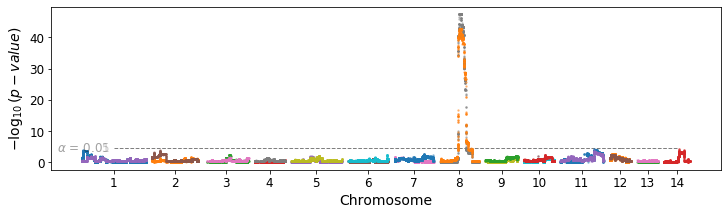

In [421]:
## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values+cumpos,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
plt.hlines(threshold,chrommap.Midpts.min(),
           19*10**6,linewidth=1,alpha=0.5,
           linestyle='--',color='k')

plt.text(chrommap.Midpts.min()-100000,threshold,
         '$\u03B1$ = 0.01',
         fontsize=12,alpha=0.2,
         ha='right',va='center')

for i,j in chrommap[:-1].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = amoeba[(amoeba.index == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values+cumpos,temp.Pval.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
plt.hlines(threshold,chrommap.Midpts.max(),
           19*10**6,linewidth=1,alpha=0.5,
           linestyle='--',color='k')

plt.text(chrommap.Midpts.min()-100000,threshold,
         '$\u03B1$ = 0.05',
         fontsize=12,alpha=0.2,
         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.

#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_QTL_Bt22xFtc555-1.png", 
#            dpi = 100, bbox_inches = "tight")

In [422]:
clear_path = '../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_average.csv'

In [423]:
clear = pd.read_csv(clear_path, index_col = 0)

clear.head()

,Replicate,Halo,Halo_in
PMY,,,
PMY2649,2.041667,30.820458,4.777181
PMY2650,2.000000,6.688159,1.036667
PMY2556,1.500000,21.406409,3.318000
PMY2557,1.500000,16.628999,2.577500
PMY2558,1.500000,7.051599,1.093000


In [424]:
Halo

,Sample,Replicate,Melanin,QTL
Sample,,,,
PMY2649,PMY2649,18.5,13340.877778,0
PMY2650,PMY2650,18.5,1598.561111,1
PMY2556,PMY2556,2.0,950.066667,1
PMY2558,PMY2558,2.0,5484.500000,0
PMY2559,PMY2559,2.0,1884.333333,0
...,...,...,...,...
PMY2936,PMY2936,2.0,6826.233333,0
PMY2937,PMY2937,2.0,1015.400000,1
PMY2938,PMY2938,2.0,1929.766667,1


In [425]:
Qtl.dtypes

GT                    int64
Melanin             float64
QTL1                 object
Chromosome 1 QTL     object
QTL7                 object
Chromosome 7 QTL     object
dtype: object

In [426]:
pheno = pd.merge(Qtl, clear, left_index=True, right_on='PMY')

pheno.head()

,GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Replicate,Halo,Halo_in
PMY,,,,,,,,,
PMY2556,1,950.066667,1,Ftc555-1,0,Bt22,1.5,21.406409,3.3180
PMY2558,1,5484.500000,0,Bt22,1,Ftc555-1,1.5,7.051599,1.0930
PMY2559,1,1884.333333,1,Ftc555-1,0,Bt22,1.5,4.329024,0.6710
PMY2560,1,787.233333,0,Bt22,0,Bt22,1.5,3.896766,0.6040
PMY2561,1,1292.100000,0,Bt22,1,Ftc555-1,1.5,10.764495,1.6685


In [427]:
pheno.shape

(307, 9)

In [428]:
def objective(x, a, b, c):
	return a * x + b * x**2 + c

from scipy.optimize import curve_fit

In [429]:
x, y = pheno.Melanin, pheno.Halo

popt, _ = curve_fit(objective, x, y)

a, b, c = popt

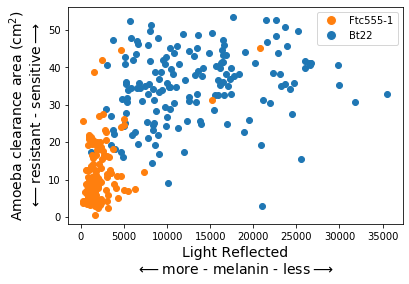

In [430]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Ftc555-1',
                          markerfacecolor='tab:orange', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Bt22',
                          markerfacecolor='tab:blue', markersize=10)] # for making a custom legend

colors = {'0':'blue','1':'tab:orange'}

groups = pheno.groupby('GT')

fig, ax = plt.subplots(1,1,figsize=(6,4))

for i,j in groups:
    ax.plot(j.Melanin, j.Halo, marker = 'o', linestyle='', label=i)
ax.legend()


#x_line = np.arange(min(x), max(x))

#y_line = objective(x_line, a, b, c)

ax.legend(handles=legend_elements, loc='upper right')
plt.ylabel('Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$',fontsize=14) ## Add x label.
plt.xlabel(myylabel,fontsize=14); ## add y label
#plt.plot(x_line, y_line, '--', color='red')

plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_Amoeba_regression_Bt22xFtc555-1.png", 
            dpi = 100, bbox_inches = "tight")

In [431]:
ftc8 = pheno[pheno.GT == 1]

In [432]:
ftc8.head()

,GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Replicate,Halo,Halo_in
PMY,,,,,,,,,
PMY2556,1,950.066667,1,Ftc555-1,0,Bt22,1.5,21.406409,3.3180
PMY2558,1,5484.500000,0,Bt22,1,Ftc555-1,1.5,7.051599,1.0930
PMY2559,1,1884.333333,1,Ftc555-1,0,Bt22,1.5,4.329024,0.6710
PMY2560,1,787.233333,0,Bt22,0,Bt22,1.5,3.896766,0.6040
PMY2561,1,1292.100000,0,Bt22,1,Ftc555-1,1.5,10.764495,1.6685


In [433]:
resftc = smf.ols('Melanin~Halo',data=ftc8).fit()
resftc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     38.59
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           5.47e-09
Time:                        10:51:32   Log-Likelihood:                -1300.0
No. Observations:                 144   AIC:                             2604.
Df Residuals:                     142   BIC:                             2610.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    689.9894    285.516      2.417      0.017     125.578    1254.401
Halo         125.8507     20.260      6.212      0.000      85.800     165.901
==============================================================================
Omnibus:                      147.006   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3077.064
Skew:                           3.652   Prob(JB):                         0.00
Kurtosis:                      24.436   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [434]:
x = np.linspace(-1,-1,1000)
y = 689.9894*x+285.516

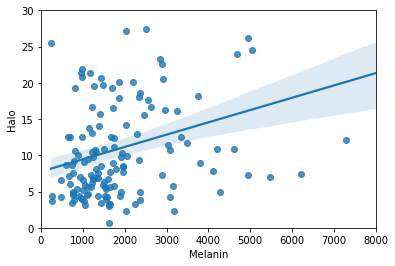

In [435]:
sns.regplot(ftc8.Melanin, ftc8.Halo);
plt.ylim(0,30);
plt.xlim(0,8000);

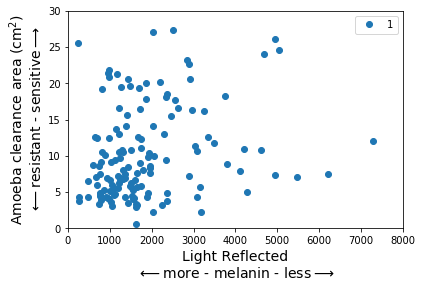

In [436]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Ftc555-1',
                          markerfacecolor='tab:orange', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Bt22',
                          markerfacecolor='tab:blue', markersize=10)] # for making a custom legend

colors = {'0':'blue','1':'tab:orange'}

groups = ftc8.groupby('GT')

fig, ax = plt.subplots(1,1,figsize=(6,4))

for i,j in groups:
    ax.plot(j.Melanin, j.Halo, marker = 'o', linestyle='', label=i)
    plt.plot(x, y, '-r')
ax.legend()


plt.ylim(0,30)
plt.xlim(0,8000)

plt.ylabel('Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$',fontsize=14) ## Add x label.
plt.xlabel(myylabel,fontsize=14); ## add y label
#plt.plot(x_line, y_line, '--', color='red')

#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_Amoeba_regression_Bt22xFtc555-1.png", 
#            dpi = 100, bbox_inches = "tight")

In [437]:
pheno

,GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Replicate,Halo,Halo_in
PMY,,,,,,,,,
PMY2556,1,950.066667,1,Ftc555-1,0,Bt22,1.5,21.406409,3.318000
PMY2558,1,5484.500000,0,Bt22,1,Ftc555-1,1.5,7.051599,1.093000
PMY2559,1,1884.333333,1,Ftc555-1,0,Bt22,1.5,4.329024,0.671000
PMY2560,1,787.233333,0,Bt22,0,Bt22,1.5,3.896766,0.604000
PMY2561,1,1292.100000,0,Bt22,1,Ftc555-1,1.5,10.764495,1.668500
...,...,...,...,...,...,...,...,...,...
PMY2936,0,6826.233333,1,Ftc555-1,1,Ftc555-1,2.0,34.464447,5.342000
PMY2937,1,1015.400000,1,Ftc555-1,0,Bt22,2.0,6.660202,1.032333
PMY2938,1,1929.766667,1,Ftc555-1,0,Bt22,2.0,10.337614,1.602333


In [438]:
pheno.to_csv('../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_mel_pehno.csv', index = True)

In [439]:
robin = ['PMY2776','PMY2765','PMY2768','PMY2745','PMY2747','PMY2715','PMY2570','PMY2581','PMY2911']



In [440]:
pheno.loc[robin]

,GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Replicate,Halo,Halo_in
PMY,,,,,,,,,
PMY2776,1,1951.266667,1,Ftc555-1,0,Bt22,2.0,8.369876,1.297333
PMY2765,1,1626.900000,1,Ftc555-1,1,Ftc555-1,2.0,3.303219,0.512000
PMY2768,1,3173.633333,1,Ftc555-1,1,Ftc555-1,2.0,2.329028,0.361000
PMY2745,0,6326.533333,0,Bt22,1,Ftc555-1,2.0,22.673073,3.514333
PMY2747,0,13877.800000,1,Ftc555-1,1,Ftc555-1,2.0,24.731133,3.833333
PMY2715,0,3812.600000,0,Bt22,0,Bt22,2.0,22.219310,3.444000
PMY2570,0,15196.966667,0,Bt22,1,Ftc555-1,1.5,49.241837,7.632500
PMY2581,0,22587.766667,1,Ftc555-1,1,Ftc555-1,1.5,52.535379,8.143000
PMY2911,0,23647.866667,1,Ftc555-1,0,Bt22,2.0,50.797748,7.873667


In [441]:
Qtl.astype({'GT': 'float64'}).dtypes

GT                  float64
Melanin             float64
QTL1                 object
Chromosome 1 QTL     object
QTL7                 object
Chromosome 7 QTL     object
dtype: object

In [442]:
Qtl["GT"] = Qtl.GT.astype('float64')

Qtl.rename(columns={'GT':'Melanin_GT'}, inplace = True)

Qtl.head()

,Melanin_GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL
PMY2556,1.0,950.066667,1,Ftc555-1,0,Bt22
PMY2558,1.0,5484.500000,0,Bt22,1,Ftc555-1
PMY2559,1.0,1884.333333,1,Ftc555-1,0,Bt22
PMY2560,1.0,787.233333,0,Bt22,0,Bt22
PMY2561,1.0,1292.100000,0,Bt22,1,Ftc555-1


In [443]:
meba.rename(columns={'GT':'Amoeba_GT'}, inplace = True)

meba.head()

,Sample,Amoeba_GT,Halo,QTL5,Chromosome 5 QTL
Sample,,,,,
PMY2556,PMY2556,1.0,21.406409,0.0,Bt22
PMY2558,PMY2558,1.0,7.051599,0.0,Bt22
PMY2559,PMY2559,1.0,4.329024,1.0,Ftc555-1
PMY2560,PMY2560,1.0,3.896766,1.0,Ftc555-1
PMY2561,PMY2561,1.0,10.764495,0.0,Bt22


In [444]:
peaks = pd.merge(Qtl, meba, left_index=True, right_index=True)

peaks.head()

,Melanin_GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Sample,Amoeba_GT,Halo,QTL5,Chromosome 5 QTL
PMY2556,1.0,950.066667,1,Ftc555-1,0,Bt22,PMY2556,1.0,21.406409,0.0,Bt22
PMY2558,1.0,5484.500000,0,Bt22,1,Ftc555-1,PMY2558,1.0,7.051599,0.0,Bt22
PMY2559,1.0,1884.333333,1,Ftc555-1,0,Bt22,PMY2559,1.0,4.329024,1.0,Ftc555-1
PMY2560,1.0,787.233333,0,Bt22,0,Bt22,PMY2560,1.0,3.896766,1.0,Ftc555-1
PMY2561,1.0,1292.100000,0,Bt22,1,Ftc555-1,PMY2561,1.0,10.764495,0.0,Bt22


In [445]:
peaks[(peaks.Melanin_GT == 1) & (peaks.QTL1 == 0) & (peaks.QTL7 == 1) & (peaks.Amoeba_GT == 1)& (peaks.QTL5 == 1)].count()

Melanin_GT          13
Melanin             13
QTL1                13
Chromosome 1 QTL    13
QTL7                13
Chromosome 7 QTL    13
Sample              13
Amoeba_GT           13
Halo                13
QTL5                13
Chromosome 5 QTL    13
dtype: int64

In [446]:
import itertools

In [447]:
a = [1,1,1]
b = [1,0,0]

Combinations = list(itertools.product(range(2), repeat=5))

#Combinations

In [448]:
Combinationsdf = pd.DataFrame(Combinations)
Combinationsdf.drop_duplicates().shape, Combinationsdf.drop_duplicates()

((32, 5),
     0  1  2  3  4
 0   0  0  0  0  0
 1   0  0  0  0  1
 2   0  0  0  1  0
 3   0  0  0  1  1
 4   0  0  1  0  0
 5   0  0  1  0  1
 6   0  0  1  1  0
 7   0  0  1  1  1
 8   0  1  0  0  0
 9   0  1  0  0  1
 10  0  1  0  1  0
 11  0  1  0  1  1
 12  0  1  1  0  0
 13  0  1  1  0  1
 14  0  1  1  1  0
 15  0  1  1  1  1
 16  1  0  0  0  0
 17  1  0  0  0  1
 18  1  0  0  1  0
 19  1  0  0  1  1
 20  1  0  1  0  0
 21  1  0  1  0  1
 22  1  0  1  1  0
 23  1  0  1  1  1
 24  1  1  0  0  0
 25  1  1  0  0  1
 26  1  1  0  1  0
 27  1  1  0  1  1
 28  1  1  1  0  0
 29  1  1  1  0  1
 30  1  1  1  1  0
 31  1  1  1  1  1)

In [449]:
Combined = Combinationsdf.drop_duplicates().reset_index()

In [450]:
test = peaks

it = []

for i,j in Combined.iterrows():
    comb = peaks[(peaks.Melanin_GT == j[0]) &
          (peaks.QTL1 == j[1]) &
          (peaks.QTL7 == j[2]) &
          (peaks.Amoeba_GT == j[3]) &
          (peaks.QTL5 == j[4])].index.values
    df1 = pd.DataFrame(index = comb)
    
    df1['group'] = i
    
    it.append(df1)

In [451]:
it = [df for df in it if not df.empty]

Groups = pd.concat(it)

Groups.head()

,group
PMY2594,0
PMY2635,0
PMY2643,0
PMY2649,0
PMY2699,0


In [452]:
byqtl = pd.merge(peaks, Groups, right_index=True, left_index=True)

byqtl.head()

,Melanin_GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Sample,Amoeba_GT,Halo,QTL5,Chromosome 5 QTL,group
PMY2556,1.0,950.066667,1,Ftc555-1,0,Bt22,PMY2556,1.0,21.406409,0.0,Bt22,26
PMY2558,1.0,5484.500000,0,Bt22,1,Ftc555-1,PMY2558,1.0,7.051599,0.0,Bt22,22
PMY2559,1.0,1884.333333,1,Ftc555-1,0,Bt22,PMY2559,1.0,4.329024,1.0,Ftc555-1,27
PMY2560,1.0,787.233333,0,Bt22,0,Bt22,PMY2560,1.0,3.896766,1.0,Ftc555-1,19
PMY2561,1.0,1292.100000,0,Bt22,1,Ftc555-1,PMY2561,1.0,10.764495,0.0,Bt22,22


In [453]:
Vals = byqtl.group.unique().tolist()

Combinationsdf.loc[Vals].sort_index().T

,0,1,4,5,8,9,12,13,14,18,19,22,23,26,27,30,31
0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
1,0,0,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1
2,0,0,1,1,0,0,1,1,1,0,0,1,1,0,0,1,1
3,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
4,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1


In [454]:
#byqtl_means[byqtl_means.group == g]

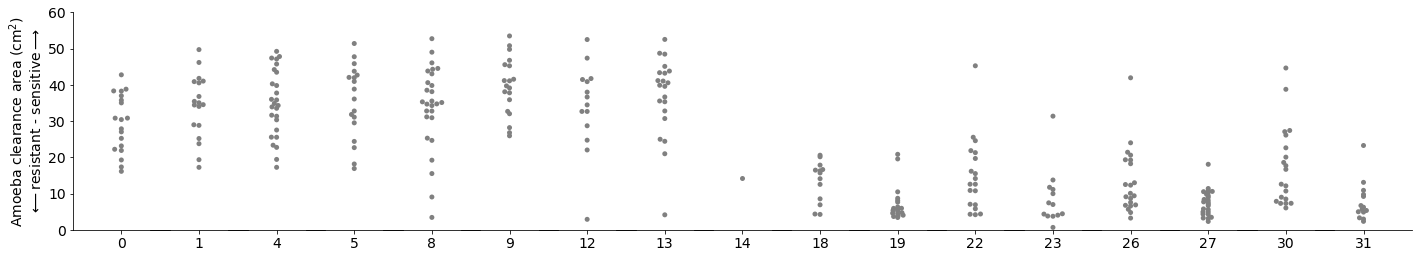

In [455]:
fig,ax = plt.subplots(1,17,figsize=(24,4),sharey=False)

i = 0

for g in byqtl.sort_values('group').group.unique():
    plt.sca(ax[i])
    sns.swarmplot(x='group',
              y='Halo',data=byqtl[(byqtl.group==g)],size=5,
             color='grey')
    
#    sns.scatterplot(x = "group",
#                y = "Halo",
#                color = "red",
#                marker='v',
#                s=150,
#                zorder=3,
#                ax=ax,
#                legend=False,
#                data=byqtl_means[byqtl_means.group == g])
    
    plt.ylim(0,60)
    plt.xlabel('')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    plt.subplots_adjust(wspace=-.2)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    
    if i == 0:
        plt.ylabel('Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$', fontsize = 14);
        
    else:
        plt.ylabel('');
        plt.yticks([])
        ax[i].spines['left'].set_visible(False)
        
    i = i+1

    
    
    
plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Amoeba_split_QTL_all_Bt22xFtc555-1.png", 
            dpi = 100, bbox_inches = "tight")

In [456]:
peaks[(peaks.Melanin_GT == 1) & (peaks.QTL1 == 0) & (peaks.QTL7 == 1)].count()

Melanin_GT          32
Melanin             32
QTL1                32
Chromosome 1 QTL    32
QTL7                32
Chromosome 7 QTL    32
Sample              32
Amoeba_GT           32
Halo                32
QTL5                32
Chromosome 5 QTL    32
dtype: int64

In [457]:
a = [1,1,1]
b = [1,0,0]

Combinations = list(itertools.product(range(2), repeat=3))

#Combinations

In [458]:
Combinationsdf = pd.DataFrame(Combinations)
Combinationsdf.drop_duplicates().shape, Combinationsdf.drop_duplicates()

((8, 3),
    0  1  2
 0  0  0  0
 1  0  0  1
 2  0  1  0
 3  0  1  1
 4  1  0  0
 5  1  0  1
 6  1  1  0
 7  1  1  1)

In [459]:
Combined = Combinationsdf.drop_duplicates().reset_index()

In [460]:
test = peaks

it = []

for i,j in Combined.iterrows():
    comb = peaks[(peaks.Melanin_GT == j[0]) &
          (peaks.QTL1 == j[1]) &
          (peaks.QTL7 == j[2])].index.values
    df1 = pd.DataFrame(index = comb)
    
    df1['group'] = i
    
    it.append(df1)

In [461]:
it = [df for df in it if not df.empty]

Groups = pd.concat(it)

Groups.head()

,group
PMY2594,0
PMY2608,0
PMY2612,0
PMY2635,0
PMY2643,0


In [462]:
byqtl = pd.merge(peaks, Groups, right_index=True, left_index=True)

byqtl.head()

,Melanin_GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Sample,Amoeba_GT,Halo,QTL5,Chromosome 5 QTL,group
PMY2556,1.0,950.066667,1,Ftc555-1,0,Bt22,PMY2556,1.0,21.406409,0.0,Bt22,6
PMY2558,1.0,5484.500000,0,Bt22,1,Ftc555-1,PMY2558,1.0,7.051599,0.0,Bt22,5
PMY2559,1.0,1884.333333,1,Ftc555-1,0,Bt22,PMY2559,1.0,4.329024,1.0,Ftc555-1,6
PMY2560,1.0,787.233333,0,Bt22,0,Bt22,PMY2560,1.0,3.896766,1.0,Ftc555-1,4
PMY2561,1.0,1292.100000,0,Bt22,1,Ftc555-1,PMY2561,1.0,10.764495,0.0,Bt22,5


In [463]:
Vals = byqtl.group.unique().tolist()

Combinationsdf.loc[Vals].sort_index().T

,0,1,2,3,4,5,6,7
0,0,0,0,0,1,1,1,1
1,0,0,1,1,0,0,1,1
2,0,1,0,1,0,1,0,1


In [464]:
byqtl.isin(Parent_PMY)

,Melanin_GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Sample,Amoeba_GT,Halo,QTL5,Chromosome 5 QTL,group
PMY2556,False,False,False,False,False,False,False,False,False,False,False,False
PMY2558,False,False,False,False,False,False,False,False,False,False,False,False
PMY2559,False,False,False,False,False,False,False,False,False,False,False,False
PMY2560,False,False,False,False,False,False,False,False,False,False,False,False
PMY2561,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
PMY2936,False,False,False,False,False,False,False,False,False,False,False,False
PMY2937,False,False,False,False,False,False,False,False,False,False,False,False
PMY2938,False,False,False,False,False,False,False,False,False,False,False,False
PMY2939,False,False,False,False,False,False,False,False,False,False,False,False


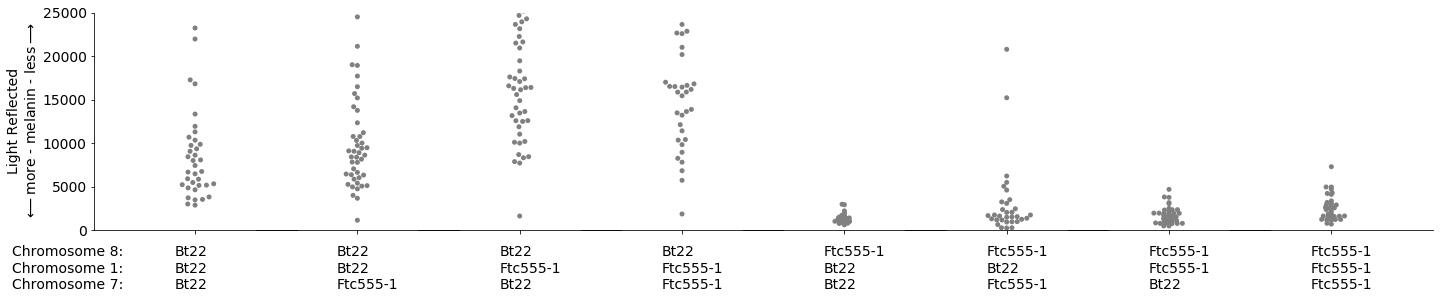

In [465]:
fig,ax = plt.subplots(1,8,figsize=(24,4),sharey=False)

i = 0

for g in byqtl.sort_values('group').group.unique():
    plt.sca(ax[i])
    sns.swarmplot(x='group',
              y='Melanin',data=byqtl[(byqtl.group==g)],size=5,
             color='grey')
    
    t,b,m = list(map(lambda x:"Bt22" if x==0 else "Ftc555-1", Combinationsdf.T[g]))
    yh = -6750
    
    plt.text(x=-0.1,y=yh,s='%s\n%s\n%s'%(t, b, m),
                 fontsize=14,ha='left')
    
    
#xc = [0,1,2,3,4,5,6,7]

#for i,b in enumerate(['Bt22','Ftc555-1']):
#    for j,f in enumerate(['Bt22','Ftc555-1']):
#        for x,v in enumerate(['Bt22','Ftc555-1']):
#            plt.text(x=xc[int((2*i)+j + x)]-0.17,y=yh,s='%s\n%s\n%s'%(b,f,v),
#                 fontsize=14,ha='left')
    
    plt.ylim([0,25000])
    plt.xlabel('')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    plt.subplots_adjust(wspace=-.2)
    plt.xticks([0],[],fontsize=14)
    plt.yticks(fontsize=14)
    
    
    if i == 0:
        plt.ylabel(myylabel, fontsize = 14);
        
    else:
        plt.ylabel('');
        plt.yticks([])
        ax[i].spines['left'].set_visible(False)
        
    i = i+1

plt.text(x=-6.5,y=yh,s='Chromosome 8:\nChromosome 1:\nChromosome 7:',fontsize=14);
    
    
plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Amoeba_split_QTL_all_Bt22xFtc555-1.png", 
            dpi = 150, bbox_inches = "tight")

In [466]:
byqtl.head()

,Melanin_GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Sample,Amoeba_GT,Halo,QTL5,Chromosome 5 QTL,group
PMY2556,1.0,950.066667,1,Ftc555-1,0,Bt22,PMY2556,1.0,21.406409,0.0,Bt22,6
PMY2558,1.0,5484.500000,0,Bt22,1,Ftc555-1,PMY2558,1.0,7.051599,0.0,Bt22,5
PMY2559,1.0,1884.333333,1,Ftc555-1,0,Bt22,PMY2559,1.0,4.329024,1.0,Ftc555-1,6
PMY2560,1.0,787.233333,0,Bt22,0,Bt22,PMY2560,1.0,3.896766,1.0,Ftc555-1,4
PMY2561,1.0,1292.100000,0,Bt22,1,Ftc555-1,PMY2561,1.0,10.764495,0.0,Bt22,5


In [467]:
model = 'Melanin~Melanin_GT + QTL1'
mod = smf.ols(model,data=byqtl)
res = mod.fit()
#qtlfun.modelprint(res2,'C:\\Users\\Thomas\\Pictures\\scientific figures\\Mel_Model2.png')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     196.1
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           2.02e-55
Time:                        10:51:36   Log-Likelihood:                -3055.8
No. Observations:                 307   AIC:                             6118.
Df Residuals:                     304   BIC:                             6129.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.113e+04    497.109     22.396      0.000    1.02e+04    1.21e+04
QTL1[T.1]   3817.2500    585.361      6.521      0.000    2665.378    4969.122
Melanin_GT -1.113e+04    585.585    -19.015      0.000   -1.23e+04   -9982.642
==============================================================================
Omnibus:                       63.484   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.154
Skew:                           1.081   Prob(JB):                     1.10e-27
Kurtosis:                       5.243   Cond. No.                         3.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [468]:
model2 = 'Melanin~Melanin_GT + QTL7'
mod2 = smf.ols(model2,data=byqtl)
res2 = mod2.fit()
#qtlfun.modelprint(res2,'C:\\Users\\Thomas\\Pictures\\scientific figures\\Mel_Model2.png')
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     153.4
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           8.53e-47
Time:                        10:51:36   Log-Likelihood:                -3075.8
No. Observations:                 307   AIC:                             6158.
Df Residuals:                     304   BIC:                             6169.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.297e+04    525.956     24.658      0.000    1.19e+04     1.4e+04
QTL7[T.1]    172.1243    624.141      0.276      0.783   -1056.059    1400.307
Melanin_GT -1.093e+04    624.593    -17.498      0.000   -1.22e+04   -9699.935
==============================================================================
Omnibus:                       55.815   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.971
Skew:                           0.993   Prob(JB):                     1.19e-22
Kurtosis:                       4.988   Cond. No.                         3.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [469]:
byqtl.head()

,Melanin_GT,Melanin,QTL1,Chromosome 1 QTL,QTL7,Chromosome 7 QTL,Sample,Amoeba_GT,Halo,QTL5,Chromosome 5 QTL,group
PMY2556,1.0,950.066667,1,Ftc555-1,0,Bt22,PMY2556,1.0,21.406409,0.0,Bt22,6
PMY2558,1.0,5484.500000,0,Bt22,1,Ftc555-1,PMY2558,1.0,7.051599,0.0,Bt22,5
PMY2559,1.0,1884.333333,1,Ftc555-1,0,Bt22,PMY2559,1.0,4.329024,1.0,Ftc555-1,6
PMY2560,1.0,787.233333,0,Bt22,0,Bt22,PMY2560,1.0,3.896766,1.0,Ftc555-1,4
PMY2561,1.0,1292.100000,0,Bt22,1,Ftc555-1,PMY2561,1.0,10.764495,0.0,Bt22,5


In [470]:
model3 = 'Melanin~Melanin_GT + QTL1 + QTL7'
mod3 = smf.ols(model3,data=byqtl)
res3 = mod3.fit()
#qtlfun.modelprint(res2,'C:\\Users\\Thomas\\Pictures\\scientific figures\\Mel_Model2.png')
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     130.9
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           2.16e-54
Time:                        10:51:36   Log-Likelihood:                -3055.4
No. Observations:                 307   AIC:                             6119.
Df Residuals:                     303   BIC:                             6134.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.085e+04    588.653     18.438      0.000    9695.053     1.2e+04
QTL1[T.1]   3864.4777    587.976      6.573      0.000    2707.444    5021.512
QTL7[T.1]    521.3576    587.276      0.888      0.375    -634.298    1677.013
Melanin_GT -1.112e+04    586.015    -18.976      0.000   -1.23e+04   -9967.334
==============================================================================
Omnibus:                       63.880   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.937
Skew:                           1.084   Prob(JB):                     4.50e-28
Kurtosis:                       5.269   Cond. No.                         3.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [471]:
import qtlfunctions as qtlfun

In [472]:
geno_ch8 = qtlfun.findchrom(geno,c=8)
geno_ch8.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2931,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940
Oldindex,,,,,,,,,,,,,,,,,,,,,
52560,8,38163,TCTGAA.TATGAA.TTTGAA,snp,38163,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0
52561,8,40940,GCT.ACT,snp,40940,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0
52562,8,42061,G.A,snp,42061,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0
52564,8,42150,CAT.TAT,snp,42150,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0
52565,8,44571,A.G,snp,44571,8.0,8.0,0.491857,1,1,...,1,0,0,1,0,1,0,0,1,0


In [473]:
cila, cira

(726529.0, 773990.0)

In [474]:
geno_ch8.Pos.max(), geno_ch8.Pos.min()

(1387111, 38163)

In [475]:
geno_ch8.shape

(3310, 330)

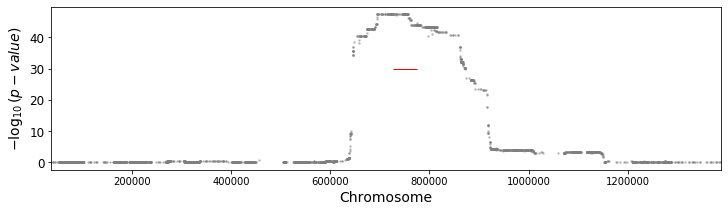

In [476]:
## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = geno_8ci[(geno_8ci.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
    
#plt.hlines(threshold,chrommap.Midpts.min(),
#           21*10**6,linewidth=1,alpha=0.5,
#           linestyle='--',color='k')

plt.hlines(30,cila,cira,color='r',linewidth=1)

#plt.text(chrommap.Midpts.min()-100000,threshold,
#         '$\u03B1$ = 0.05',
#         fontsize=12,alpha=0.2,
#         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
#plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
#           fontsize=12); ## set location, labels and fontsize of x tics.
plt.xlim(38163,1387111);


#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_QTL_Bt22xFtc555-1.png", 
#            dpi = 100, bbox_inches = "tight")

In [477]:
geno_front = geno[['Chrom', 'Pos', 'Alleles', 'Type', 'Newpos', 'Newchrom', 'Oldchrom', 'Maf']]

geno_front

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf
Oldindex,,,,,,,,
5,1,25980,C.T,snp,25980,1.0,1.0,0.491857
7,1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857
12,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857
15,1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857
17,1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857
...,...,...,...,...,...,...,...,...
89836,14,915487,GTGCG.ATGCG.GTGTG,snp,915487,14.0,14.0,0.472313
89838,14,918283,A.G,snp,918283,14.0,14.0,0.472313
89840,14,923437,TAGA.CAGA,snp,923437,14.0,14.0,0.472313


In [478]:
geno_8_0 = pd.merge(geno_front, loci0, left_index=True, right_index=True)

In [479]:
geno_front.shape, loci0.shape, geno_8_0.shape

((46760, 8), (3199, 163), (3199, 171))

In [480]:
geno_ch1 = qtlfun.findchrom(geno_8_0,c=1)
geno_ch1.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2565,PMY2567,...,PMY2919,PMY2920,PMY2922,PMY2926,PMY2929,PMY2931,PMY2933,PMY2934,PMY2935,PMY2936
Oldindex,,,,,,,,,,,,,,,,,,,,,
5,1,25980,C.T,snp,25980,1.0,1.0,0.491857,0,1,...,1,1,0,0,0,0,1,0,1,0
91,1,47201,TAGG.AAGG,snp,47201,1.0,1.0,0.511401,0,1,...,1,1,0,0,1,0,1,0,1,0
96,1,48326,C.T,snp,48326,1.0,1.0,0.485342,0,1,...,1,1,0,0,0,0,1,0,1,0
153,1,54290,GGT.AGT,snp,54290,1.0,1.0,0.491857,0,1,...,1,1,0,0,0,0,1,0,1,0
192,1,55882,TGAGTGGGGGAAAAGGAAGAA.CGAGTGGGGGAAAAGGAAGAA.TG...,snp,55882,1.0,1.0,0.495114,0,1,...,1,1,0,0,0,0,1,0,0,0


In [481]:
geno_ch1.Pval.max()

AttributeError: 'DataFrame' object has no attribute 'Pval'

In [ ]:
mel0 = pheno.loc[Map_pop0]['Melanin'].values

In [ ]:
cil1,cir1,boots1 = qtlfun.bootci(geno_ch1,qtlfun.allelic_manu,
                                Map_pop0,mel0,nboots=50)

## View head of boots
boots1.head()

In [ ]:
cil1, cir1

In [ ]:
geno_1ci = pd.merge(geno_ch1, pvaldf)

geno_1ci.head()

In [ ]:
geno_1ci.Pos.min(), geno_1ci.Pos.max()

In [ ]:
## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = geno_1ci[(geno_1ci.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values,temp.Pval0.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
    
#plt.hlines(threshold,chrommap.Midpts.min(),
#           21*10**6,linewidth=1,alpha=0.5,
#           linestyle='--',color='k')

plt.hlines(5,cil1,cir1,color='r',linewidth=1)

#plt.text(chrommap.Midpts.min()-100000,threshold,
#         '$\u03B1$ = 0.05',
#         fontsize=12,alpha=0.2,
#         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
#plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
#           fontsize=12); ## set location, labels and fontsize of x tics.
plt.xlim(38163,1387111);


#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Melanin_QTL_Bt22xFtc555-1.png", 
#            dpi = 100, bbox_inches = "tight")

In [ ]:
geno